**About the Data**

In this notebook, we will be working with 2 data sets:
- Facebook's stock price throughout 2018 (obtained using the stock_analysis package).
- daily weather data for NYC from the National Centers for Environmental Information (NCEI) API.

Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the
NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for the NCEI weather API to find the updated one.

**Background on the weather data**

Data meanings:
AWND : average wind speed
PRCP : precipitation in millimeters
SNOW : snowfall in millimeters
SNWD : snow depth in millimeters
TMAX : maximum daily temperature in Celsius
TMIN : minimum daily temperature in Celsius


# Setup

In [127]:
import numpy as n
import pandas as p

wthr = p.read_csv('/content/nycweather2k18 8.2.csv',parse_dates=['date'])
wthr.head()

,date,datatype,station,attributes,value
0,2018-01-01,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [128]:
fb = p.read_csv('/content/fb_2018.csv', index_col='date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


# Arithmetic and statistics

We already saw that we can use mathematical operators like + and / with dataframes directly. However, we can also use methods, which allow us to specify the axis to
perform the calculation over. By default this is per column. Let's find the z-scores for the volume traded and look at the days where this was more than 3 standard deviations
from the mean:


In [129]:
fb.assign(abs_z_score_vloume=lambda x: x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()).query('abs_z_score_vloume>3')

,open,high,low,close,volume,abs_z_score_vloume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


We can use rank() and pct_change() to see which days had the largest change in volume traded from the day before:

In [130]:
fb.assign(volume_pct_change=fb.volume.pct_change(),
          pct_change_rank=lambda x: x.volume_pct_change.abs().rank(ascending=False)).nsmallest(5, 'pct_change_rank')

,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


January 12th was when the news that Facebook changed its news feed product to focus more on content from a users' friends over the brands they follow. Given that
Facebook's advertising is a key component of its business (nearly 89% in 2017), many shares were sold and the price dropped in panic:


In [131]:
fb['2018-01-11':"2018-01-12"]

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


Throughout 2018, Facebook's stock price never had a low above $215:

In [132]:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

**Binning and thresholds**

When working with the volume traded, we may be interested in ranges of volume rather than the exact values. No two days have the same volume traded:

In [133]:
(fb.volume.value_counts() > 1).sum()

0

We can use pd.cut() to create 3 bins of even an even range in volume traded and name them. Then we can work with low, medium, and high volume traded categories:


In [134]:
volume_binned = p.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

low     240
med       8
high      3
Name: volume, dtype: int64

In [135]:
fb[volume_binned == 'high'].sort_values(
    'volume', ascending=False)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


July 25th Facebook announced disappointing user growth and the stock tanked in the after hours:


In [136]:
fb['2018-07-25':'2018-07-26']

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


Cambridge Analytica scandal broke on Saturday March 17th, so we look to the Monday for the numbers:

In [137]:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


Since most days have similar volume, but a few are very large, we have very wide bins. Most of the data is in the low bin.
Note: visualizations will be covered in chapters 5 and 6.


In [138]:
import matplotlib.pyplot as plt

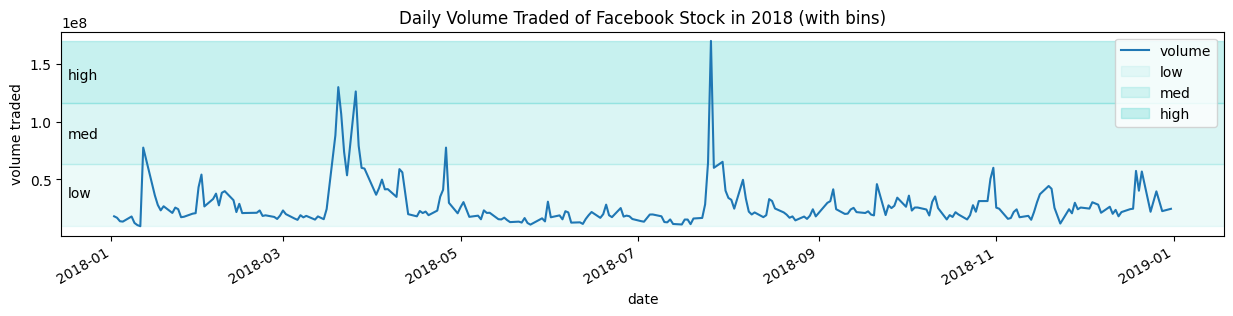

In [139]:
fb.plot(y='volume', figsize=(15, 3), title='Daily Volume Traded of Facebook Stock in 2018 (with bins)')

for bin_name, alpha, bounds in zip(
    ['low', 'med', 'high'], [0.1, 0.2, 0.3], p.cut(fb.volume, bins=3).unique().categories.values):
  plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
  plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))


plt.ylabel('volume traded')
plt.legend()
plt.show()

If we split using quantiles, the bins will have roughly the same number of observations. For this, we use qcut() . We will make 4 quartiles:

In [140]:
volume_qbinned = p.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

q1    63
q2    63
q4    63
q3    62
Name: volume, dtype: int64

Notice the bins don't cover ranges of the same size anymore:

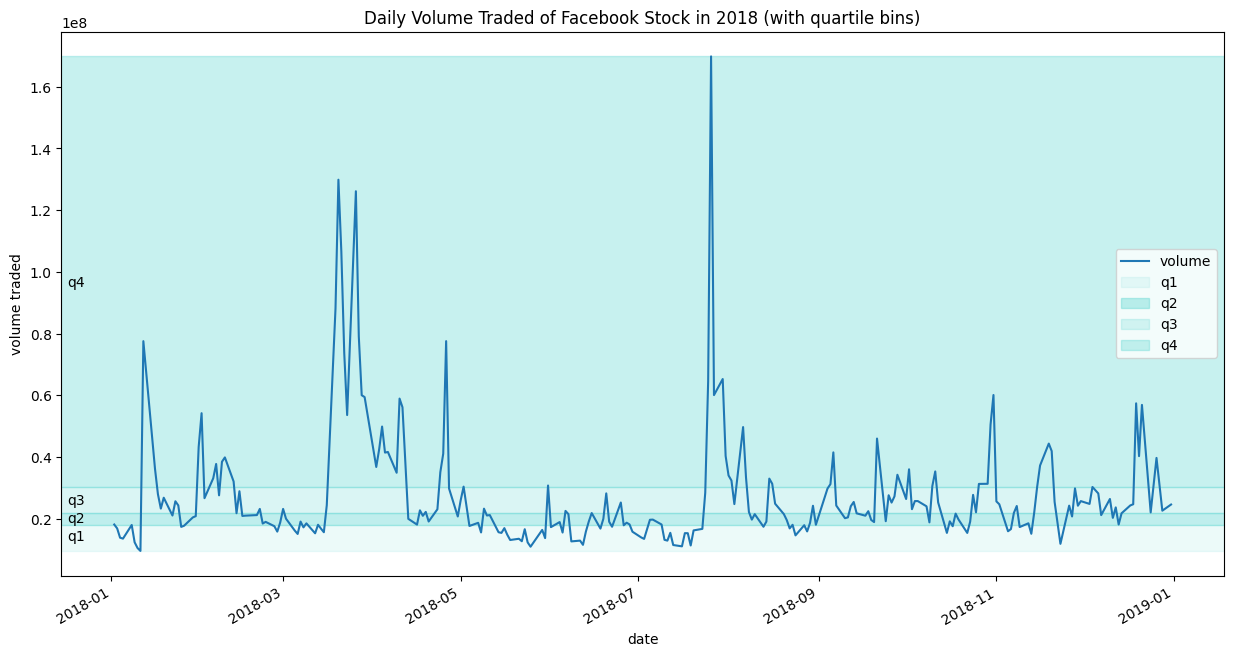

In [141]:
fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')

for bin_name, alpha, bounds in zip(
    ['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], p.qcut(fb.volume, q=4).unique().categories.values):
  plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
  plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

Sometimes we don't want to make bins, but rather cap values at a threshold. Before we look at an example, let's pivot our weather data for the Central Park station:


In [142]:
cpw = wthr.query(
    'station == "GHCND:USW00094728"'
).pivot(index='date', columns='datatype', values='value')
cpw.head(17)

datatype,ADPT,ASLP,ASTP,AWBT,AWND,PRCP,RHAV,RHMN,RHMX,SNOW,...,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT06,WT08
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-194.0,10278.0,10224.0,-122.0,3.5,0.0,48.0,34.0,60.0,0.0,...,-13.8,300.0,300.0,6.7,11.2,NaN,NaN,NaN,NaN,NaN
2018-01-02,-156.0,10278.0,10227.0,-94.0,3.6,0.0,52.0,42.0,62.0,0.0,...,-10.5,260.0,250.0,7.2,12.5,NaN,NaN,NaN,NaN,NaN
2018-01-03,-161.0,10237.0,10196.0,-78.0,1.4,0.0,42.0,28.0,51.0,0.0,...,-8.8,260.0,270.0,6.3,9.8,NaN,NaN,NaN,NaN,NaN
2018-01-04,-94.0,9990.0,9925.0,-61.0,5.6,19.3,70.0,39.0,92.0,249.0,...,-7.1,310.0,310.0,10.7,19.2,1.0,1.0,NaN,NaN,1.0
2018-01-05,-206.0,10098.0,10030.0,-128.0,5.8,0.0,43.0,33.0,56.0,0.0,...,-12.7,280.0,280.0,9.4,15.7,NaN,NaN,NaN,NaN,NaN
2018-01-06,-228.0,10237.0,10186.0,-139.0,4.9,0.0,42.0,32.0,55.0,0.0,...,-14.3,310.0,310.0,8.9,13.9,NaN,NaN,NaN,NaN,NaN
2018-01-07,-194.0,10325.0,10274.0,-128.0,2.9,0.0,48.0,38.0,57.0,0.0,...,-14.9,250.0,250.0,7.2,12.5,NaN,NaN,NaN,NaN,NaN
2018-01-08,-111.0,10217.0,10163.0,-56.0,2.6,0.3,58.0,47.0,72.0,0.0,...,-8.2,250.0,240.0,6.7,12.1,NaN,NaN,NaN,NaN,1.0
2018-01-09,-56.0,10217.0,10166.0,0.0,3.0,0.0,56.0,40.0,72.0,0.0,...,-1.0,310.0,330.0,6.7,12.1,NaN,NaN,NaN,NaN,NaN


Say we don't care how much snow their was, just that it snowed in Central Park. However, we don't want to make a Boolean column since we need to preserve the data type of
float. We can use clip() to replace values above a upper threshold with the threshold and replace values below a lower threshold with the lower threshold. This means we
can use clip(0, 1) to change all the snow values of one or more to 1, which easily shows us the days snow was recorded in Central Park. Preserving the data type will
save some work later on if we are building a model:

In [143]:
cpw.SNOW.clip(0, 1).value_counts()

0.0    350
1.0     11
Name: SNOW, dtype: int64

Note: the clip() method can also be called on the dataframe itself.

**Applying Functions**

We can use the apply() method to run the same operation on all columns (or rows) of the dataframe. Let's calculate the z-scores of the TMIN, TMAX, and PRCP
observations in Central Park in October 2018:


In [144]:
oct_weather_z_scores = cpw.loc['2018-10', ['TMIN', 'TMAX', 'PRCP']].apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,29.0,5.742533e-17,1.0,-1.361157,-0.765991,-0.485912,1.072025,1.859746
TMAX,29.0,-1.643800e-16,1.0,-1.323770,-0.838925,-0.163605,0.979243,1.567983
PRCP,29.0,3.062684e-17,1.0,-0.409621,-0.409621,-0.409621,-0.240293,3.797529


October 27th rained much more than the rest of the days

In [145]:
oct_weather_z_scores.query('PRCP > 3')

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-27,-0.765991,-1.219874,3.797529


Indeed, this day was much higher than the rest:

In [146]:
cpw.loc['2018-10', 'PRCP'].describe()

count    29.000000
mean      3.144828
std       7.677406
min       0.000000
25%       0.000000
50%       0.000000
75%       1.300000
max      32.300000
Name: PRCP, dtype: float64

When the function we want to apply isn't vectorized, we can:
- use np.vectorize() to vectorize it (similar to how map() works) and then use it with apply()
- use applymap() and pass it the non-vectorized function directly

Say we wanted to count the digits of the whole numbers for the Facebook data. len() is not vectorized:

In [147]:
fb.apply(lambda x: n.vectorize(lambda y: len(str(n.ceil(y))))(x)).astype('int64').equals(fb.applymap(lambda x: len(str(n.ceil(x)))))

True

A simple operation of addition to each element in a series grows linearly in time complexity when using iteritems() , but stays near 0 when using vectorized operations.
iteritems() and related methods should only be used if there is no vectorized solution:


<ipython-input-148-119458c20245>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, v in test.iteritems():


<Axes: title={'center': 'Time Complexity of Vectorized Operations vs. iteritems()'}>

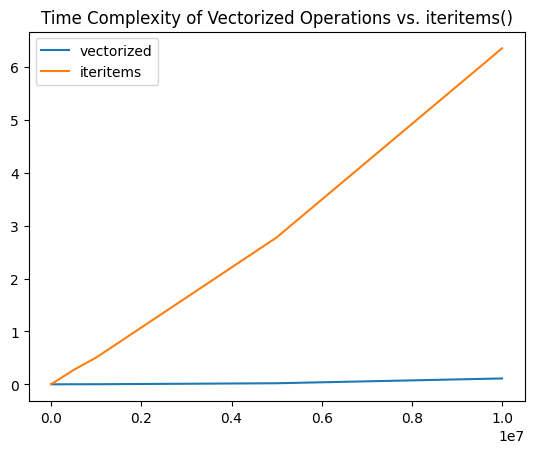

In [148]:
import time

n.random.seed(0)
vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
  test = p.Series(n.random.uniform(size=size))
  start = time.time()
  x = test + 10
  end = time.time()
  vectorized_results[size] = end - start

  start = time.time()
  x = []
  for i, v in test.iteritems():
    x.append(v + 10)
  x = p.Series(x)
  end = time.time()
  iteritems_results[size] = end - start

p.DataFrame([p.Series(vectorized_results, name='vectorized'), p.Series(iteritems_results, name='iteritems')]
            ).T.plot(title='Time Complexity of Vectorized Operations vs. iteritems()')

**Window Calculations**

Consult the understanding windows calculation notebook for interactive visualizations to help understand window calculations.

The rolling() method allows us to perform rolling window calculations. We simply specify the window size (3 days here) and follow it with a call to an aggregation
function (sum here):


In [149]:
cpw['2018-10'].assign(rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T

<ipython-input-149-2161e5c1013a>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  cpw['2018-10'].assign(rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()


date,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-07,2018-10-08
datatype,,,,,,,
PRCP,0.0,17.5,0.0,1.0,0.0,0.0,0.0
rolling_PRCP,0.0,17.5,17.5,18.5,1.0,0.0,0.0


We can also perform the rolling calculations on the entire dataframe at once. This will apply the same aggregation function to each column:


In [150]:
cpw['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]

<ipython-input-150-1d719be06c78>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  cpw['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]


datatype,ADPT,ASLP,ASTP,AWBT,AWND,PRCP
date,,,,,,
2018-10-01,172.000000,10247.000000,10200.000000,189.000000,0.900000,0.000000
2018-10-02,180.500000,10221.500000,10176.000000,194.500000,0.900000,8.750000
2018-10-03,172.333333,10205.333333,10159.000000,187.000000,0.966667,5.833333
2018-10-04,176.000000,10175.000000,10128.333333,187.000000,0.800000,6.166667
2018-10-05,155.666667,10177.333333,10128.333333,170.333333,1.033333,0.333333
2018-10-07,164.000000,10213.500000,10160.500000,180.500000,1.350000,0.000000
2018-10-08,186.000000,10256.000000,10201.500000,197.000000,1.450000,0.000000


We can use different aggregation functions per column if we use agg() instead. We pass in a dictionary mapping the column to the aggregation to perform on it:

In [151]:
cpw['2018-10-01':'2018-10-07'].rolling('3D').agg({'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
 cpw[['TMAX', 'TMIN', 'AWND', 'PRCP']],
 lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals

datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-07,1.1,1.350000,0.0,0.0,26.1,26.1,19.4,15.6


Rolling calculations ( rolling() ) use a sliding window. Expanding calculations ( expanding() ) however grow in size. These are equivalent to cumulative aggregations like
cumsum() ; however, we can specify the minimum number of periods required to start calculating (default is 1):


In [152]:
cpw.PRCP.expanding().sum().equals(cpw.PRCP.cumsum())

False

Separate expanding aggregations per column. Note that agg() will accept numpy functions too:


In [153]:
cpw['2018-10-01':'2018-10-07'].expanding().agg(
 {'TMAX': n.max, 'TMIN': n.min, 'AWND': n.mean, 'PRCP': n.sum}
).join(
 cpw[['TMAX', 'TMIN', 'AWND', 'PRCP']],
 lsuffix='_expanding'
).sort_index(axis=1)


datatype,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.825000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,0.980000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-07,1.1,1.000000,0.0,18.5,26.1,26.1,19.4,15.6


We can calculate the exponentially weighted moving average as follows. Note that span here is the periods to use:

In [154]:
fb.assign(
 close_ewma=lambda x: x.close.ewm(span=5).mean()
).tail(10)[['close', 'close_ewma']]

,close,close_ewma
date,,
2018-12-17,140.19,142.235433
2018-12-18,143.66,142.710289
2018-12-19,133.24,139.553526
2018-12-20,133.40,137.502350
2018-12-21,124.95,133.318234
2018-12-24,124.06,130.232156
2018-12-26,134.18,131.548104
2018-12-27,134.52,132.538736
2018-12-28,133.20,132.759157


Consult the understanding_window_calculations.ipynb notebook for interactive visualizations to help understand window calculations.


**Pipes**

Pipes all use to apply any function that accepts our data as the first argument and pass in any additional arguments. This makes it easy to chain steps together regardless of if
they are methods or functions:

We can pass any function that will accept the caller of pipe() as the first argument:


In [155]:
def get_info(df):
 return '%d rows and %d columns and max closing z-score was %d' % (*df.shape, df.close.max())
fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
 == get_info(fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))

<ipython-input-155-df4ec8f2b7d9>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
<ipython-input-155-df4ec8f2b7d9>:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  == get_info(fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))


True

For example, passing pd.DataFrame.rolling to pipe() is equivalent to calling rolling() directly on the dataframe, except we have more flexiblity to change this:

In [156]:
fb.pipe(p.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

True

The pipe takes the function passed in and calls it with the object that called pipe() as the first argument. Positional and keyword arguments are passed down:

In [157]:
p.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

True

We can use a pipe to make a function that we can use for all our window calculation needs:


In [158]:
def window_calc(df, func, agg_dict, *args, **kwargs):
  return df.pipe(func, *args, **kwargs).agg(agg_dict)

We can use the same interface to calculate various window calculations now. Let's find the expanding median for the Facebook data:

In [159]:
window_calc(fb, p.DataFrame.expanding, n.median).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.580,177.5500,181.420,18151903.0
2018-01-03,179.78,183.180,179.4400,183.045,17519233.0
2018-01-04,181.88,184.780,181.3300,184.330,16886563.0
2018-01-05,183.39,185.495,182.7148,184.500,15383729.5
2018-01-08,184.90,186.210,184.0996,184.670,16886563.0


Using the exponentially weighted moving average requires we pass in a keyword argument:

In [160]:
window_calc(fb, p.DataFrame.ewm, 'mean', span=3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.680000,181.580000,177.550000,181.420000,1.815190e+07
2018-01-03,180.480000,183.713333,180.070000,183.586667,1.730834e+07
2018-01-04,183.005714,185.140000,182.372629,184.011429,1.534980e+07
2018-01-05,184.384000,186.078667,183.736560,185.525333,1.440299e+07
2018-01-08,185.837419,187.534839,185.075110,186.947097,1.625679e+07


With rolling calculations, we can pass in a positional argument for the window size:

In [161]:
window_calc(
 cpw['2018-10'],
 p.DataFrame.rolling,
 {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'},
 '3D'
).head()

<ipython-input-161-cc089c14c022>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  cpw['2018-10'],


datatype,TMAX,TMIN,AWND,PRCP
date,,,,
2018-10-01,24.4,17.2,0.900000,0.0
2018-10-02,25.0,17.2,0.900000,17.5
2018-10-03,25.0,17.2,0.966667,17.5
2018-10-04,25.0,16.1,0.800000,18.5
2018-10-05,24.4,15.6,1.033333,1.0
